# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [10]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



# Function for feature building and extraction on natural language data

In [10]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        #hv = CountVectorizer() #189777
        #hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False) #131074
        hv = HashingVectorizer(n_features=2 ** 9, alternate_sign=False) # 514
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of CountVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of CountVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        #sc = MinMaxScaler()
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [17]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='./toxiccomments_train.csv', my_random_seed=15)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# SVC with Different  Regularizations

In [20]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

clf_1 = SVC(C = 1e-4, max_iter=1000)
clf_1.fit(X_train, y_train)

clf_performance_train_1 = BinaryClassificationPerformance(clf_1.predict(X_train), y_train, 'clf_train_1')
clf_performance_train_1.compute_measures()
print(clf_performance_train_1.performance_measures)

/Users/yuyuan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'Pos': 13000, 'Neg': 114656, 'TP': 9625, 'TN': 82035, 'FP': 32621, 'FN': 3375, 'Accuracy': 0.718023437989597, 'Precision': 0.2278322208019694, 'Recall': 0.7403846153846154, 'desc': 'clf_train_1'}


In [21]:
clf_2 = SVC(C = 1e-3, max_iter=1000)
clf_2.fit(X_train, y_train)

clf_performance_train_2 = BinaryClassificationPerformance(clf_2.predict(X_train), y_train, 'clf_train_2')
clf_performance_train_2.compute_measures()
print(clf_performance_train_2.performance_measures)

/Users/yuyuan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'Pos': 13000, 'Neg': 114656, 'TP': 9635, 'TN': 82983, 'FP': 31673, 'FN': 3365, 'Accuracy': 0.7255279814501473, 'Precision': 0.23324779703689358, 'Recall': 0.7411538461538462, 'desc': 'clf_train_2'}


In [22]:
clf_3 = SVC(C = 1e-2, max_iter=1000)
clf_3.fit(X_train, y_train)

clf_performance_train_3 = BinaryClassificationPerformance(clf_3.predict(X_train), y_train, 'clf_train_3')
clf_performance_train_3.compute_measures()
print(clf_performance_train_3.performance_measures)

/Users/yuyuan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'Pos': 13000, 'Neg': 114656, 'TP': 10744, 'TN': 78519, 'FP': 36137, 'FN': 2256, 'Accuracy': 0.6992464122328759, 'Precision': 0.22917599880548623, 'Recall': 0.8264615384615385, 'desc': 'clf_train_3'}


In [23]:
clf_4 = SVC(C = 1e-1, max_iter=1000)
clf_4.fit(X_train, y_train)

clf_performance_train_4 = BinaryClassificationPerformance(clf_4.predict(X_train), y_train, 'clf_train_4')
clf_performance_train_4.compute_measures()
print(clf_performance_train_4.performance_measures)

/Users/yuyuan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'Pos': 13000, 'Neg': 114656, 'TP': 9432, 'TN': 84998, 'FP': 29658, 'FN': 3568, 'Accuracy': 0.7397223788932756, 'Precision': 0.24128933231005373, 'Recall': 0.7255384615384616, 'desc': 'clf_train_4'}


In [24]:
clf_5 = SVC(C = 1, max_iter=1000)
clf_5.fit(X_train, y_train)

clf_performance_train_5 = BinaryClassificationPerformance(clf_5.predict(X_train), y_train, 'clf_train_5')
clf_performance_train_5.compute_measures()
print(clf_performance_train_5.performance_measures)

/Users/yuyuan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'Pos': 13000, 'Neg': 114656, 'TP': 7255, 'TN': 90384, 'FP': 24272, 'FN': 5745, 'Accuracy': 0.764860249420317, 'Precision': 0.23012021441938657, 'Recall': 0.558076923076923, 'desc': 'clf_train_5'}


In [25]:
clf_6 = SVC(C = 10, max_iter=1000)
clf_6.fit(X_train, y_train)

clf_performance_train_6 = BinaryClassificationPerformance(clf_6.predict(X_train), y_train, 'clf_train_6')
clf_performance_train_6.compute_measures()
print(clf_performance_train_6.performance_measures)

/Users/yuyuan/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


{'Pos': 13000, 'Neg': 114656, 'TP': 7531, 'TN': 84459, 'FP': 30197, 'FN': 5469, 'Accuracy': 0.7206085103716238, 'Precision': 0.19961301950805768, 'Recall': 0.5793076923076923, 'desc': 'clf_train_6'}


### ROC plot to compare performance of various models and fits

/var/folders/xb/cbktfhg92ng2z19072jvt4340000gn/T/ipykernel_42590/2590429220.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'],


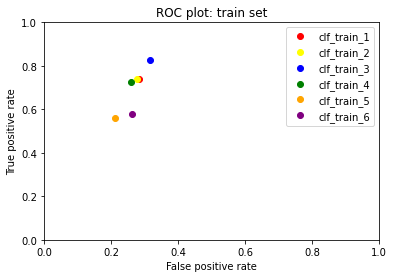

In [27]:
fits = [clf_performance_train_1,clf_performance_train_2,clf_performance_train_3,clf_performance_train_4,clf_performance_train_5,
       clf_performance_train_6]
colors = ['red','yellow','blue','green','orange','purple']

for i in range(len(fits)):
    fit = fits[i]
    color = colors[i]
    label = fit.desc
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo',color=color, label=label)
    plt.legend(loc='upper right')
    #plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
    #         fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    
#plt.plot(x, y, linewidth = '1', label = "test", color=' coral ', linestyle=':', marker='|')
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()


### let's look at some false positives:

In [22]:
clf_6_predictions = clf_6.predict(X_train)

In [30]:
# false positives

print("Examples of false positives:")

import random, time
'''
for i in range(0, len(clf_6_predictions)):
    if (clf_6_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')
'''

Examples of false positives:


"\nfor i in range(0, len(clf_6_predictions)):\n    if (clf_6_predictions[i] == 1):\n        if (X_raw_train.iloc[i]['any_toxic'] == 0):\n            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives\n                print(i)\n                print(X_raw_train.iloc[i]['comment_text'])\n                print('* * * * * * * * * ')\n"

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: SVC

In [31]:
clf_performance_test_1 = BinaryClassificationPerformance(clf_1.predict(X_test), y_test, 'clf_test_1')
clf_performance_test_1.compute_measures()
print(clf_performance_test_1.performance_measures)

{'Pos': 3225, 'Neg': 28690, 'TP': 2393, 'TN': 20738, 'FP': 7952, 'FN': 832, 'Accuracy': 0.7247689174369418, 'Precision': 0.23131947800869984, 'Recall': 0.742015503875969, 'desc': 'clf_test_1'}


In [33]:
clf_performance_test_2 = BinaryClassificationPerformance(clf_2.predict(X_test), y_test, 'clf_test_2')
clf_performance_test_2.compute_measures()
print(clf_performance_test_2.performance_measures)

{'Pos': 3225, 'Neg': 28690, 'TP': 2404, 'TN': 20939, 'FP': 7751, 'FN': 821, 'Accuracy': 0.7314115619614602, 'Precision': 0.23673067454455934, 'Recall': 0.7454263565891472, 'desc': 'clf_test_2'}


In [34]:
clf_performance_test_3 = BinaryClassificationPerformance(clf_3.predict(X_test), y_test, 'clf_test_3')
clf_performance_test_3.compute_measures()
print(clf_performance_test_3.performance_measures)

{'Pos': 3225, 'Neg': 28690, 'TP': 2628, 'TN': 19839, 'FP': 8851, 'FN': 597, 'Accuracy': 0.7039636534544885, 'Precision': 0.22893980311873857, 'Recall': 0.8148837209302325, 'desc': 'clf_test_3'}


In [35]:
clf_performance_test_4 = BinaryClassificationPerformance(clf_4.predict(X_test), y_test, 'clf_test_4')
clf_performance_test_4.compute_measures()
print(clf_performance_test_4.performance_measures)

{'Pos': 3225, 'Neg': 28690, 'TP': 2259, 'TN': 21328, 'FP': 7362, 'FN': 966, 'Accuracy': 0.739056869810434, 'Precision': 0.23479887745556596, 'Recall': 0.7004651162790698, 'desc': 'clf_test_4'}


In [36]:
clf_performance_test_5 = BinaryClassificationPerformance(clf_5.predict(X_test), y_test, 'clf_test_5')
clf_performance_test_5.compute_measures()
print(clf_performance_test_5.performance_measures)

{'Pos': 3225, 'Neg': 28690, 'TP': 1642, 'TN': 22417, 'FP': 6273, 'FN': 1583, 'Accuracy': 0.7538461538461538, 'Precision': 0.20745420088439673, 'Recall': 0.5091472868217054, 'desc': 'clf_test_5'}


In [37]:
clf_performance_test_6 = BinaryClassificationPerformance(clf_6.predict(X_test), y_test, 'clf_test_6')
clf_performance_test_6.compute_measures()
print(clf_performance_test_6.performance_measures)

{'Pos': 3225, 'Neg': 28690, 'TP': 1690, 'TN': 21016, 'FP': 7674, 'FN': 1535, 'Accuracy': 0.7114522951590161, 'Precision': 0.18047842802221273, 'Recall': 0.524031007751938, 'desc': 'clf_test_6'}


### ROC plot to compare performance of various models and fits

/var/folders/xb/cbktfhg92ng2z19072jvt4340000gn/T/ipykernel_42590/2653158307.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'],


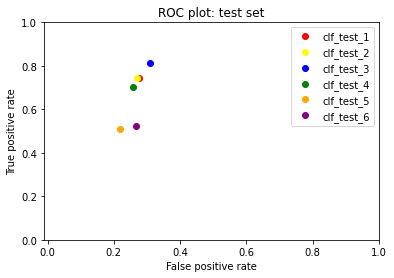

In [39]:
fits = [clf_performance_test_1,clf_performance_test_2,clf_performance_test_3,clf_performance_test_4,
       clf_performance_test_5,clf_performance_test_6]
colors = ['red','yellow','blue','green','orange','purple']


for i in range(len(fits)):
    fit = fits[i]
    color = colors[i]
    label = fit.desc
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo',color=color, label=label)
    plt.legend(loc='upper right')
    #plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
    #         fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
    
#plt.plot(x, y, linewidth = '1', label = "test", color=' coral ', linestyle=':', marker='|')
plt.axis([-0.01, 1, 0.0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()